## Ranking of estimation methods for a given dataset 

We illustrate the comparison of various estimation methods for a given datasets by ranking them according to their performance against refutation tests accounting for both the observed unmodelled confounding error and unobserved confounding error. 

In [1]:
# Importing all the required libraries
import sys
import argparse
import xgboost
import numpy as np
import pandas as pd
import os
import pdb
import random
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import mean_absolute_error
from dowhy import CausalModel
from datetime import datetime
from collections import namedtuple

import statsmodels.api as sm
from sklearn import linear_model

import dowhy
from dowhy.utils import dgp
from dowhy.utils.dgps.linear_dgp import LinearDataGeneratingProcess
from dowhy import CausalModel
from datetime import datetime
from collections import namedtuple
from dowhy.causal_refuters.add_unobserved_common_cause import AddUnobservedCommonCause

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


In [2]:
def convert_singleton_to_float(arr):
    '''Helper function.'''
    array = []

    if len(arr) == 1 and type(arr[0]) != np.ndarray:
        return arr[0]

    for element in arr:
        while type(element) == np.ndarray or isinstance(element, list) :
            if len(element) > 1:
                raise ValueError("This script only accepts one value for the refute")
            element = element[0]
        array.append(element)

    return array

In [3]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

RESULTSFOLDER = "results/"
ensure_dir(RESULTSFOLDER)
# Create the estimator named tuple to wrap the name and properties
Estimator = namedtuple('Estimator', ['name','params'])
Refuter = namedtuple('Refuter', ['name','params'])

class Experiment():
    '''
    Class to define the experiment setup to compare a list of estimators across a list of refuters for the given dataset. 
    '''
    def __init__(self, **kwargs):
        self.experiment_name = kwargs['experiment_name']
        self.experiment_id = kwargs['experiment_id']
        self.num_experiments = kwargs['num_experiments']
        self.sample_sizes = kwargs['sample_sizes']
        self.dgps = kwargs['dgps']
        self.estimators = kwargs['estimators']
        self.refuters = kwargs['refuters']
        self.results = []
        self.simulate_unobserved_confounding = kwargs["simulate_unobserved_confounding"]

        # Handle input errors in sample_sizes
        if isinstance(self.sample_sizes, list) == False:
            if type(self.sample_sizes) != int:
                raise ValueError('The input to "sample_sizes" should be an int or a list')
            else:
                self.sample_sizes = [self.sample_sizes]

        # Handle input errors in DGPs
        if isinstance(self.dgps, list) == False:
            if isinstance(self.dgps, DataGeneratingProcess) == False:
                raise ValueError('The input to "dgps" should be a list or a subclass of "DataGeneratingProcess"')
            else:
                self.dgps = [self.dgps]

        # Handle inputs errors in estimators
        if isinstance(self.estimators, list) == False:
            if isinstance(self.estimators, Estimator) == False:
                raise ValueError('The input to "estimators" should be a list or an Estimator namedtuple')
            else:
                self.estimators = [self.estimators]

        # Handle input errors in refuters
        if isinstance(self.refuters, list) == False:
            if isinstance(self.refuters, Refuter) == False:
                raise ValueError('The input to "refuters" should be a list of a Refuter namedtuple')
            else:
                self.refuters = [self.refuters]

    def experiment(self):
        print("\n\nRunning Experiment:",self.experiment_name + '_' + str(self.experiment_id) )

        for exp in range(self.num_experiments):
            print("\n\nRunning Experiment Number:",exp)

            for sample_size in self.sample_sizes:

                print("\n\nCurrent Sample Size:",sample_size)

                for dgp in self.dgps:
                    print("\n\nThe current DGP:")
                    print(dgp)
                    estimates = []
                    estimate_values = []
                    estimated_effect = []
                    new_effect = []
                    p_value = []
                    data = dgp.generate_data(sample_size)
                    print("printing data shape")
                    print(data.values.shape)
                    print(dgp.true_value)
                    print("check")
                    if dgp.treatment_is_binary:
                        data[dgp.treatment] = data[dgp.treatment].astype(bool)
                    #k = len(dgp.confounder)-4
                    #confounder_list = random.sample(dgp.confounder, k)
                    confounder_list = ['w2','w3']

                    
                    s = set(confounder_list)
                    unobserved_confounders = [x for x in dgp.confounder if x not in s]
                    df_unobserved_confounders = pd.DataFrame(data = data[[c for c in data.columns if c in unobserved_confounders]])

                    df_unobserved_confounders.to_csv("results/unobserved_confounders.csv")
                    print("printing length of confounder list:", len(confounder_list))
                    print("printing confounder list:", confounder_list)

                    

                    print("data columns")
                    
                    print("data columns", data.columns)
                    model = CausalModel(
                        data = data,
                        treatment = dgp.treatment,
                        outcome = dgp.outcome,
                        common_causes = confounder_list,
                        effect_modifiers = dgp.effect_modifier
                    )
                    model.view_model()
                    from IPython.display import Image, display
                    display(Image(filename="causal_model.png"))

                    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
                    
                    print("identified_estimand:", identified_estimand)
                    #print("identified_estimand:", identified_estimand)
                    print("\n\nRunning the estimators:\n")
                    for estimator in self.estimators:
                        print("The current estimator:", estimator)
                        print("estimator.params", estimator.params)
                        estimate = model.estimate_effect(
                            identified_estimand,
                            method_name = estimator.name,
                            method_params = estimator.params
                        )
                        print("printing estimate's type")
                        print(type(estimate))
                        estimates.append(estimate)
                        estimate_values.append(estimate.value)
                    estimate_values = convert_singleton_to_float(estimate_values)
                    print("estimate_values", estimate_values)
                    print("\n\nRunning the refuters:\n")
                    for refuter in self.refuters:
                        print("The current refuter:", refuter)
                        
                        for estimate in estimates:
                            if self.simulate_unobserved_confounding == True:
                                print("********%%%%%%%%%$$$$$&&^**^^^^*^*^*")
                                if refuter.name == 'dummy_outcome_refuter':
                                    add_unobserved_confounder = AddUnobservedCommonCause(data, identified_estimand, estimate)
                                    print("add_unobserved_confounder", add_unobserved_confounder)
                                    unobserved_confounder_values = add_unobserved_confounder.include_simulated_confounder(convergence_threshold = 0.11, c_star_max = 1500)
                                    refuter.params['unobserved_confounder_values'] = unobserved_confounder_values
                                    print('refuter.params', refuter.params)
                            refute = model.refute_estimate(
                                identified_estimand,
                                estimate,
                                method_name = refuter.name,
                                **refuter.params,
    
                                

                            )
                            print("printing refute's type")
                            print(type(refute))
                            if(refuter.name == 'dummy_outcome_refuter'):
                                refute = refute[0]
                            if refute.refutation_result is not None:
                                p_value.append(refute.refutation_result['p_value'])
                            else:
                                p_value.append(None) 

                            estimated_effect.append(refute.estimated_effect)
                            #print("refute.estimate_effect()", refute.estimate_effect())
                            new_effect.append(refute.new_effect)

                    estimated_effect = convert_singleton_to_float(estimated_effect)
                    new_effect = convert_singleton_to_float(new_effect)
                    p_value = convert_singleton_to_float(p_value)
                    true_value = convert_singleton_to_float(dgp.true_value)
                    
                    print("estimated effect", estimated_effect)
                    print("new_effect", new_effect)
                    print("p_value", p_value)
                    print("true value", true_value)
                    self.results.append([exp, sample_size, dgp.NAME, *estimate_values, *estimated_effect, *new_effect, *p_value, true_value])


        print("\n\nCompleted all experiments. Saving the data...")

        COLUMNS = ['EXPERIMENT', 'SAMPLE_SIZE', 'DGP']
        RESULT_CATEGORIES = ['ESTIMATED_EFFECT', 'NEW_EFFECT', 'P_VALUE']
        estimator_names = [estimator.name for estimator in self.estimators]
        refuter_names = [refuter.name for refuter in self.refuters]

        for estimator_name in estimator_names:
            COLUMNS += ['ORIGINAL_ESTIMATE'+ ':' + estimator_name]

        for result_category in RESULT_CATEGORIES:
            for refuter_name in refuter_names:
                for estimator_name in estimator_names:
                    COLUMNS += [refuter_name + ':' + estimator_name + ':' + result_category]

        COLUMNS += ['TRUE_VALUE']

        csv_file = RESULTSFOLDER + self.experiment_name+ '_' + str(self.experiment_id) + '_' + str(datetime.utcnow().date()) + '_data.csv'
        onlyres_csv_file = RESULTSFOLDER + "onlyres_"+ self.experiment_name+ '_' + str(self.experiment_id) + '_' + str(datetime.utcnow()) + '_data.csv'
        self.results = pd.DataFrame(data=self.results,columns=COLUMNS)
        self.results.to_csv(csv_file.replace(" ", ""), index=False)

        print("Data has been saved in ",csv_file)

        return csv_file

In [4]:
#Defining the Data Generating Process 
ldgp = LinearDataGeneratingProcess(treatment=['t1'], outcome=['y'], confounder=['w1','w2', 'w3','w4','w5','w6'], effect_modifier=['x1','x2'], seed=None, treatment_is_binary=True)

#Defining the sample size 
sample_size = 1000

dgp_dict = {'ldgp':ldgp}
dgp_list = []
dgp_list.append( dgp_dict['ldgp'] )


# Create a namedtuple to store the name of the estimator and the parameters passed
estimator_list = ["backdoor.linear_regression",
                  #"backdoor.propensity_score_stratification",
                  "backdoor.propensity_score_matching",
                  "backdoor.propensity_score_weighting",
                  "backdoor.econml.dml.DML",
                  "backdoor.econml.dr.LinearDRLearner",
                  #"backdoor.econml.metalearners.TLearner",
                  #"backdoor.econml.metalearners.XLearner",
                  #"backdoor.causalml.inference.meta.LRSRegressor",
                  #"backdoor.causalml.inference.meta.XGBTRegressor",
                  #"backdoor.causalml.inference.meta.MLPTRegressor",
                  #"backdoor.causalml.inference.meta.BaseXRegressor"
                ]
method_params= [    None,
                    #None,
                    { "init_params":{} },
                    { "init_params":{} },
                    {"init_params":{'model_y':GradientBoostingRegressor(),
                                    'model_t': GradientBoostingRegressor(),
                                    "model_final":LassoCV(fit_intercept=False),
                                    'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                     "fit_params":{}},
                    {"init_params":{ 'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto'),
                        },
                    "fit_params":{}
                    },
                    '''{"init_params": {'models': GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(sample_size/100))
                                    },
                    "fit_params":{}
                    },
                    {"init_params":{'models': GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(sample_size/100)),
                        'propensity_model': RandomForestClassifier(n_estimators=100, max_depth=6,
                                                                              min_samples_leaf=int(sample_size/100))
                        },
                     "fit_params":{}
                    },
                    {"init_params":{},},
                    {"init_params":{
                        'learner':XGBRegressor()
                        }
                    }'''
                ]
estimator_tuples = []
refuter_tuples = []

refuter_list = ['dummy_outcome_refuter']
refuter_params = [{'num_simulations':5,'transformation_list': [('random_forest',{'n_estimators':100, 'max_depth':6})], 'true_causal_effect':(lambda x:0.5)}]


# Iterate through the names and parameters to create a list of namedtuples
for name, param in zip(estimator_list,method_params):
    estimator_tuples.append(Estimator._make([name, param]))
    
for name, param in zip(refuter_list, refuter_params):
    refuter_tuples.append(Refuter._make([name, param]))


In [5]:
def plot_MAEs(res):
    true_value_column = res.columns[-1]
    estimate_columns=res.columns[3:-1]
    #print(estimate_columns)
    #print(type(estimate_columns))
    estimate_columns.append(pd.Index(res["TRUE_VALUE"]))
    #print(estimate_columns)
    fig, ax = plt.subplots()
    MAE ={}
    for colname in estimate_columns:
        if colname not in ('ORIGINAL_ESTIMATE:backdoor.propensity_score_weighting',):
                           #'ORIGINAL_ESTIMATE:backdoor.econml.metalearners.TLearner'):
            plt.plot(res[colname], res["TRUE_VALUE"], marker='o', linestyle="None", label=colname)
            "Mean Absolute Error (MAE): {}".format(mean_absolute_error(res[colname], res["TRUE_VALUE"]))
            MAE[colname] = mean_absolute_error(res[colname], res["TRUE_VALUE"])
    fig.suptitle('Calibration plot showing the accuracy of different causal estimators [P(T=1)=0.9]')
    ax.set_xlabel('Estimated effect')
    ax.set_ylabel('True causal effect')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
              fancybox=True, shadow=True, ncol=2)
    plt.show()
    print("Printing MAE of various estimates: ")
    MAE_values = {k: v for k, v in sorted(MAE.items(), key=lambda item: item[1], reverse = True)}
    for k,v in MAE_values.items():
        print(k, v)

In [6]:
def plot_estimators_and_refuters(refuter, estimator):   
    x = list(res['EXPERIMENT'])
    y1 = list(res[refuter+':'+estimator+':ESTIMATED_EFFECT'])
    y2 = list(res[refuter+':'+estimator+':NEW_EFFECT'])
    #print(res['TRUE_VALUE'])
    y3 = list(res['TRUE_VALUE'])
    y4 = list(res[refuter+':'+estimator+':P_VALUE'])
    plt.scatter(x, y1, c ="blue", label = "Estimated Effect") 
    plt.scatter(x, y2, c ="red", label = "New Effect")
    plt.scatter(x, y3, c ="green", label = "True Value")
    plt.scatter(x, y4, c ="yellow", label = "P Value")
    plt.xlabel("EXPERIMENT") 
    plt.ylabel("EFFECT")
    legend = plt.legend(loc=4, fontsize='small', fancybox=True)
    plt.title(estimator) 
    plt.show()
    plt.savefig(estimator+'.png')

In [7]:
def plot_deviations(estimator_list, deviation_list):
    plt.scatter(estimator_list, deviation_list)
    plt.xticks(estimator_list, estimator_list, rotation='vertical')
    plt.show()

## Observed unmodelled confounding error

For each estimator, we use dummy outcome refuter to check the observed unmodelled confounding error for each estimator. That is, we run the refutation test for each estimator only on the observed confounders and analyse what amount of confounding error is present unmodelled amongst the observed variables.



Running Experiment: Test_1


Running Experiment Number: 0


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {}
        bias: {}
        seed: None
        treatment_is_binary: True
        percentile: 0.9
        
printing data shape
(1000, 10)
[-1.40708596]
check
printing length of confounder list: 2
printing confounder list: ['w2', 'w3']
data columns
data columns Index(['x1', 'x2', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 't1', 'y'], dtype='object')


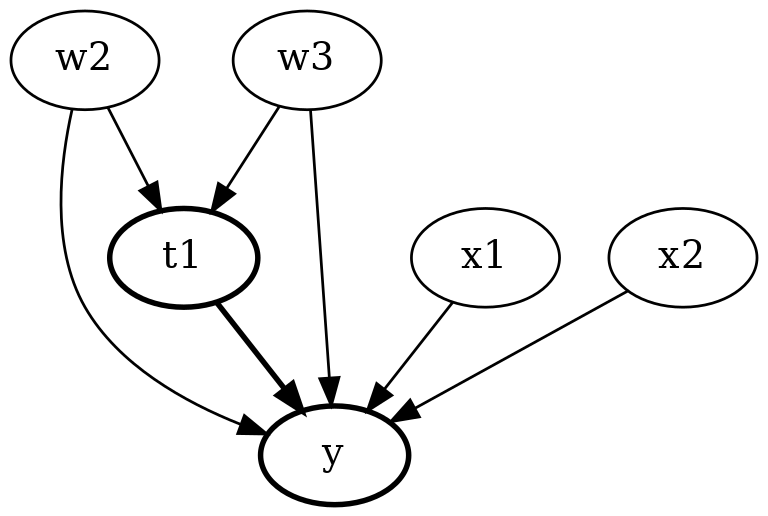

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


/home/amit/py-envs/env3.8/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionC

Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [0.13133287217224954, -1.2649545435398826, 0.7028777043823551, -0.022426109615378477, 1.3096857189259326]
p_value [0.44767982041762444, 0.21416737876633052, 0.4297022707886396, 0.37039392927548787, 0.25670736069948863]
true value -1.4070859571597596


Running Experiment Number: 1


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.63307875],
       [  0.67765016],
       [ -1.70534557],
       [ -0.26064366],
       [  1.8944517 ],
       [ -0.93801088]]), 'confounder=>outcome': array([[99.25463229],
       [ 0.29022881],
       [-0.39732969],
       [-0.41363475],
       [-0.24746944],
       [ 0.58279643]]), 'effect_m

Co-variance matrix is underdetermined. Inference will be invalid!


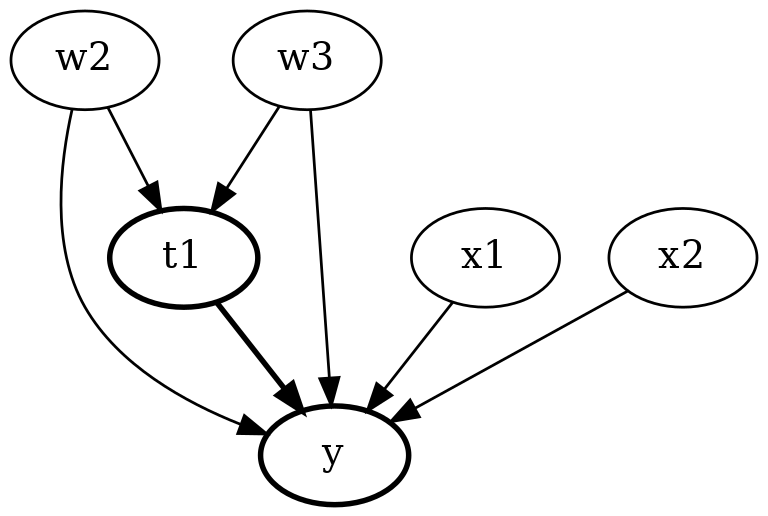

divide by zero encountered in double_scalars


identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimat

Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-3.5270585607339795, -1.51998161736145, -4.073817040696698, 3.5656094076453243e-16, -2.3594615731731006]
p_value [0.08082142460822173, 0.2170651782940205, 0.04009829321255309, 0.0, 0.08608447902450167]
true value 0.41658416841335116


Running Experiment Number: 2


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.84914040e+01],
       [ 6.52187842e-01],
       [-1.79251559e+00],
       [ 1.03258910e-02],
       [-1.26214609e+00],
       [-4.70694047e-01]]), 'confounder=>outcome': array([[98.72173376],
       [ 0.50031242],
       [-0.33762286],
       [-0.78523952],
       [-1.22114883],
       [-0.20843907]]), 'effect

Co-variance matrix is underdetermined. Inference will be invalid!


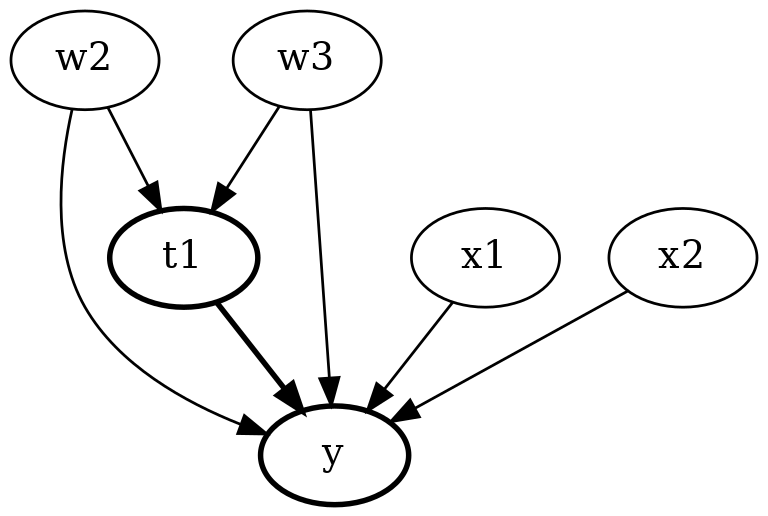

divide by zero encountered in double_scalars


identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimat

Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-0.5004958094401137, -2.7905938612146985, -2.3656323084810964, 0.33753956501557136, -4.1242561394082795]
p_value [0.3629729101595248, 0.002763601341508215, 0.08163613714595086, 0.43624639823572753, 0.1770251691426108]
true value -1.8161921626232236


Running Experiment Number: 3


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 1.00480120e+02],
       [ 7.23164038e-01],
       [-5.99362392e-01],
       [-2.64873698e-01],
       [ 9.20245621e-02],
       [ 1.76258888e-01]]), 'confounder=>outcome': array([[ 1.00576103e+02],
       [ 2.94596101e-01],
       [ 8.12961588e-02],
       [ 1.62786369e+00],
       [-1.21476009e+

Co-variance matrix is underdetermined. Inference will be invalid!


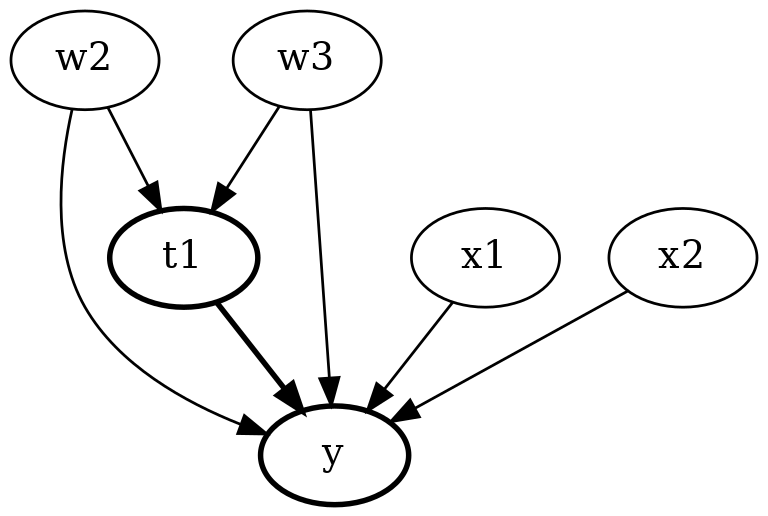

divide by zero encountered in double_scalars


identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimat

Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [0.3208681891165166, 1.4836994163286235, 2.5702583718410237, 0.39743581454551197, 2.8863979307368304]
p_value [0.46317945075278466, 0.35596726942445334, 0.23273844764945745, 0.42352603743375505, 0.1255847777646641]
true value -1.1579158444562183


Running Experiment Number: 4


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[98.73735955],
       [-0.6848361 ],
       [ 0.88085884],
       [-0.1599002 ],
       [ 0.64592644],
       [-0.59101684]]), 'confounder=>outcome': array([[100.74146011],
       [  0.57191498],
       [ -0.90418932],
       [  0.63798202],
       [ -0.72129579],
       [  1.39885232]]), 'effect_modif

Co-variance matrix is underdetermined. Inference will be invalid!


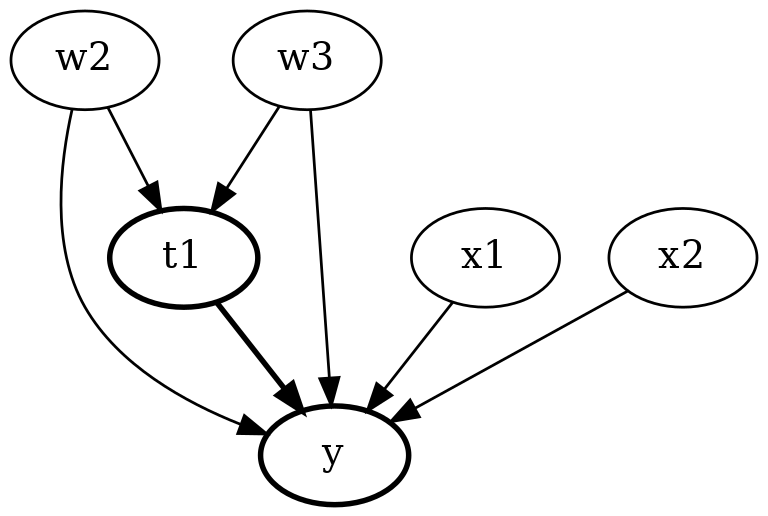

divide by zero encountered in double_scalars


identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimat

Co-variance matrix is underdetermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [54.24912895314899, 57.35296148741977, 53.915682410356034, 49.53314130038241, 53.58180818049678]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>})


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [1.308752933271999, -1.7848017659761695, 0.018199893941135768, 1.099976442869556e-16, -1.1504022225983133]
p_value [0.4056914359592948, 0.26627583398167076, 0.452781366061607, 0.0, 0.33820982769401753]
true value 1.400697760489825


Running Experiment Number: 5


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.11223425],
       [ 0.16196265],
       [ 1.24046353],
       [-0.95793589],
       [ 1.09261671],
       [-1.24512929]]), 'confounder=>outcome': array([[ 9.83005191e+01],
       [ 8.86068377e-02],
       [ 9.59883353e-01],
       [-7.03310923e-01],
       [ 1.37286587e+00],
       [-6.56481172e-01]]), 'effect_mo

Co-variance matrix is underdetermined. Inference will be invalid!


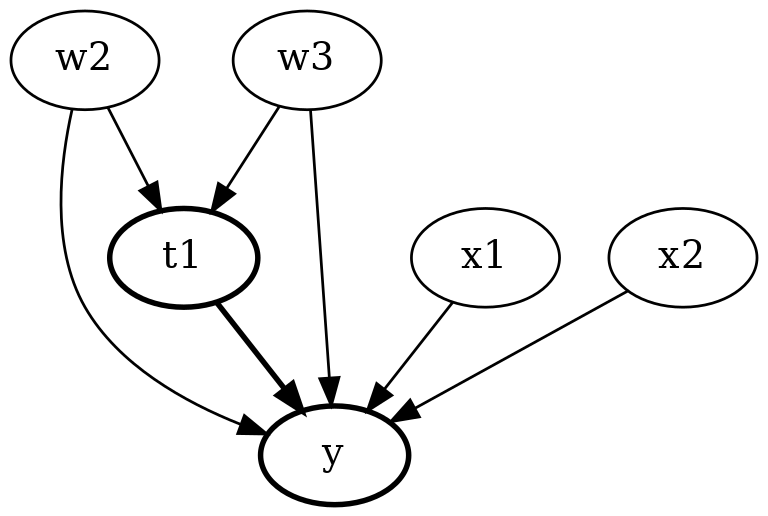

divide by zero encountered in double_scalars


identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimat

Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [58.42550157076201, 50.382950637513105, 57.49740536142247, 45.41165948070533, 59.3432569826721]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>})


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [3.1478670424194832, 1.3937129884046802, 2.610680831736128, 1.093271981713307, 3.719979127838326]
p_value [0.2521086721691, 0.35083705043818214, 0.24800770599069039, 0.3034745035352002, 0.1711464090809956]
true value 0.10095868550340063


Running Experiment Number: 6


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.93068165e+01],
       [-1.60103964e-01],
       [ 1.89103269e-01],
       [-6.93334121e-01],
       [-2.18374990e-01],
       [ 7.18940452e-03]]), 'confounder=>outcome': array([[ 1.00898932e+02],
       [ 4.96768145e-01],
       [ 6.42462385e-02],
       [-5.04904022e-01],
       [ 3.61992079e-01],
       [

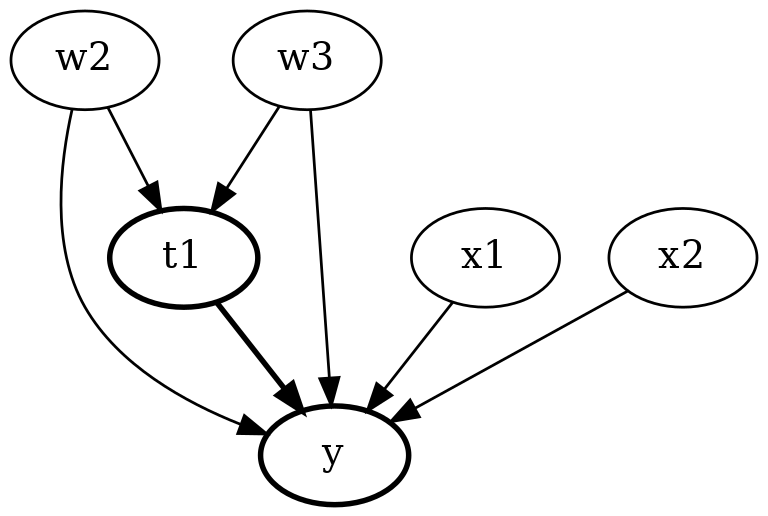

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.L

Co-variance matrix is underdetermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [53.090262432504474, 48.50854510949412, 54.74291285486841, 47.34431982563161, 52.75370671329699]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>})


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-0.8278412413409327, -3.511540837037322, -3.345448750559241, -0.15905879890619906, -2.285210097982673]
p_value [0.3696777185954918, 0.04647480677230931, 0.06951697891500541, 0.21271785853017777, 0.16453489116342568]
true value 1.0710523777793268


Running Experiment Number: 7


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.85475791],
       [-0.40328055],
       [-0.16240271],
       [ 1.94153558],
       [-0.74550511],
       [-0.41345264]]), 'confounder=>outcome': array([[ 1.00440548e+02],
       [-7.09150166e-01],
       [-1.01673025e+00],
       [ 7.33819610e-01],
       [-5.07881757e-02],
       [ 8.47774029e-0

Co-variance matrix is underdetermined. Inference will be invalid!


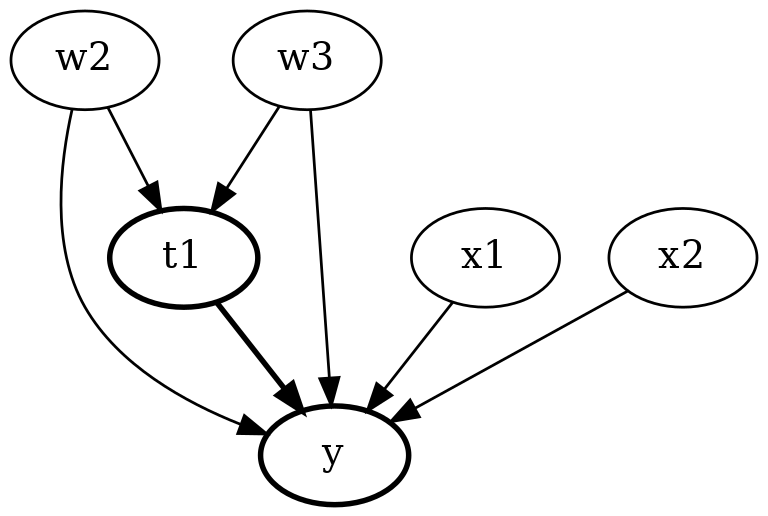

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.L

Co-variance matrix is underdetermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [53.518612568042265, 46.91316657743611, 52.17333551843868, 37.40697209256591, 53.915940635178565]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>})


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-1.3225301782873542, -0.698557770785466, 0.9367826847164741, 1.8196194155141464e-17, -1.438228790553383]
p_value [0.28729711954407167, 0.3665612203814791, 0.4310374784913009, 0.0, 0.2972496057738667]
true value -0.03221396410589567


Running Experiment Number: 8


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[98.04482943],
       [-0.9751811 ],
       [ 0.83643493],
       [ 0.82670249],
       [ 0.98306824],
       [ 0.64167563]]), 'confounder=>outcome': array([[100.78600531],
       [  1.55152653],
       [ -0.41853446],
       [ -0.16159035],
       [  0.58958435],
       [  0.63185487]]), 'effect_modifier=>outcome'

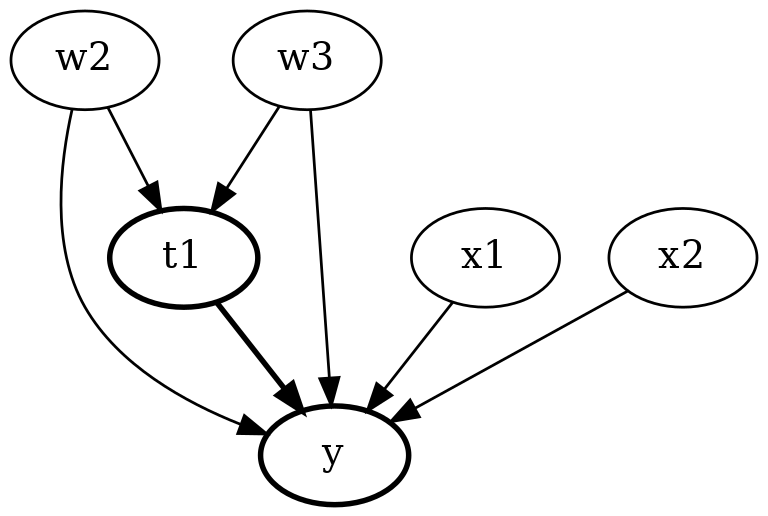

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.L

Co-variance matrix is underdetermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [71.99942433817856, 75.38759741778003, 71.28503907881684, 64.7825406951462, 71.81172374657532]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>})


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-1.181748330215269, 0.04855427295633961, -1.5413398737021453, -0.5798044477124966, -2.5589442206309965]
p_value [0.27087694215647484, 0.4640400166266019, 0.08928625402375123, 0.18925630341580457, 0.12652842829696487]
true value 1.0661746801935297


Running Experiment Number: 9


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[101.08111806],
       [ -0.36919237],
       [ -1.35756697],
       [  1.98506202],
       [ -0.11029514],
       [  0.70618213]]), 'confounder=>outcome': array([[100.46428375],
       [  1.46262546],
       [  0.80262462],
       [ -0.17645556],
       [ -0.20647154],
       [  1.8721813 ]]), 'effe

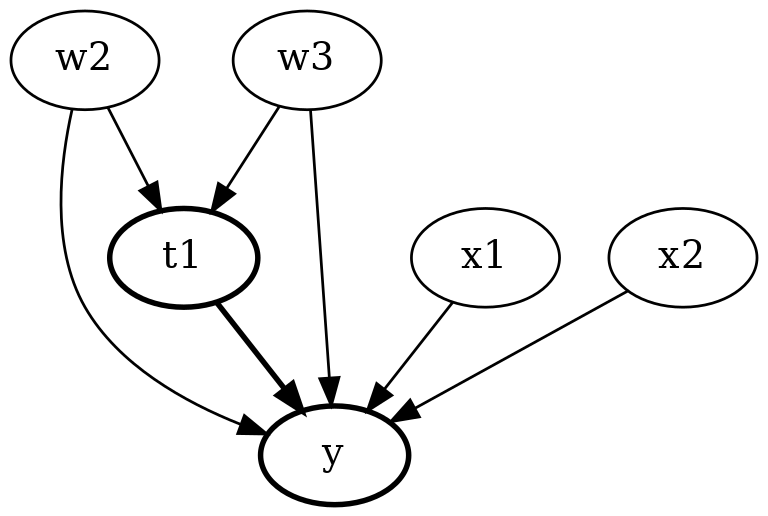

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.L

Co-variance matrix is underdetermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [56.80676471514508, 55.997982524058926, 57.19898432442315, 60.20277940146388, 56.064487660550185]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>})


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>
printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-4.076913632840683, -5.456787042627535, -4.316541671096012, -0.952337846257979, -4.131789583895926]
p_value [1.4504973822049294e-07, 0.011777130599990748, 0.004392512184785424, 0.07094828614193949, 0.10603149980157778]
true value -0.6586337528032202


Completed all experiments. Saving the data...
Data has been saved in  results/Test_1_2021-12-16_data.csv


Co-variance matrix is underdetermined. Inference will be invalid!


In [8]:
# Define the properties of the experiment
# The name of the experiment
# The experiment ID
# The number of experiments to be run with the SAME parameters
# The size of the samples to be run
# The list of DGPs to be run
# The list of estimators
observed_confounding_error = Experiment(
    experiment_name='Test',
    experiment_id='1',
    num_experiments=10, # 10
    sample_sizes=sample_size,
    dgps=dgp_list,
    estimators=estimator_tuples,
    refuters=refuter_tuples,
    simulate_unobserved_confounding = False 
)

# Run the experiment
res = pd.read_csv(observed_confounding_error.experiment())

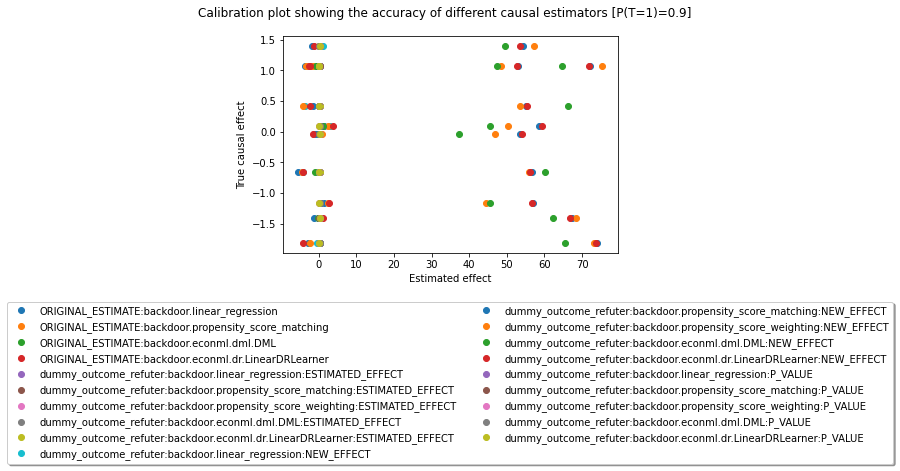

Printing MAE of various estimates: 
ORIGINAL_ESTIMATE:backdoor.linear_regression 60.23023020308968
ORIGINAL_ESTIMATE:backdoor.econml.dr.LinearDRLearner 60.09731254023777
ORIGINAL_ESTIMATE:backdoor.propensity_score_matching 57.518481752924174
ORIGINAL_ESTIMATE:backdoor.econml.dml.DML 54.51660478265596
dummy_outcome_refuter:backdoor.econml.dr.LinearDRLearner:NEW_EFFECT 2.987586762920003
dummy_outcome_refuter:backdoor.propensity_score_weighting:NEW_EFFECT 2.64211194949381
dummy_outcome_refuter:backdoor.propensity_score_matching:NEW_EFFECT 2.1237678706695995
dummy_outcome_refuter:backdoor.linear_regression:NEW_EFFECT 2.0270807853117074
dummy_outcome_refuter:backdoor.econml.dml.DML:NEW_EFFECT 1.1105346821450195
dummy_outcome_refuter:backdoor.econml.dml.DML:P_VALUE 1.0128206975197078
dummy_outcome_refuter:backdoor.linear_regression:ESTIMATED_EFFECT 1.0092423645694248
dummy_outcome_refuter:backdoor.propensity_score_matching:ESTIMATED_EFFECT 1.0092423645694248
dummy_outcome_refuter:backdoor.pr

In [9]:
#PLOT
#This plot shows the Mean Absolute Error of the Orginal Estimate from the true value and of the New Effect from 
#the expected value for each estimator. 
plot_MAEs(res)

### Ranking based on Original Estimate

The Original Estimate is calculated in the presence of the True Value (that is, the ground truth). However in many real life datasets, the ground truth may not be known. Hence, we want the ranking produced by our refutation tests to be in coherence with that obtained from the Original Estimates. According to the Original Estimate values, the ranking of the estimators should be as follows (the method with the least MAE should get the best rank):
1. DMLCateEstimator 
2. LinearRegression 
3. LinearDRLearner 
4. Propensity Score Matching 

In [10]:
estimator_list = ["backdoor.linear_regression",
                  #"backdoor.propensity_score_stratification",
                  "backdoor.propensity_score_matching",
                  "backdoor.econml.dml.DML",
                  "backdoor.econml.dr.LinearDRLearner",
                  #"backdoor.econml.metalearners.TLearner",
                  #"backdoor.econml.metalearners.XLearner",
                  #"backdoor.causalml.inference.meta.LRSRegressor",
                  #"backdoor.causalml.inference.meta.XGBTRegressor",
                  #"backdoor.causalml.inference.meta.MLPTRegressor",
                  #"backdoor.causalml.inference.meta.BaseXRegressor"
                ]

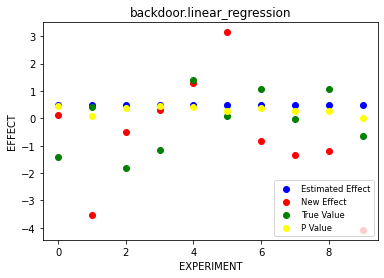

-6.527766715878084


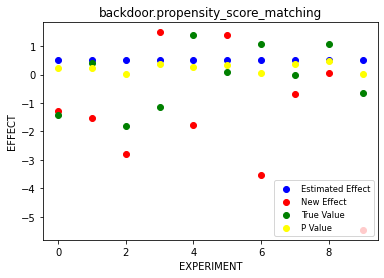

-14.101250760852881


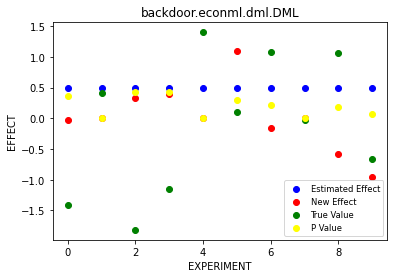

0.11462015878233744


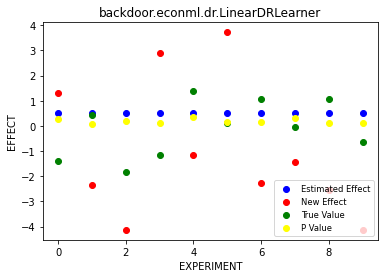

-10.132229850741584


<Figure size 432x288 with 0 Axes>

In [11]:
#This plot shows the deviation of the original estimate, the new effect and the estimated effect from the true value 
refuter = 'dummy_outcome_refuter'
deviation_list = []
for estimator in estimator_list:
    plot_estimators_and_refuters(refuter, estimator)
    avg_deviation = ((res[refuter+':'+estimator+':NEW_EFFECT']).sum(axis=0))
    print(avg_deviation)
    deviation_list.append(avg_deviation)

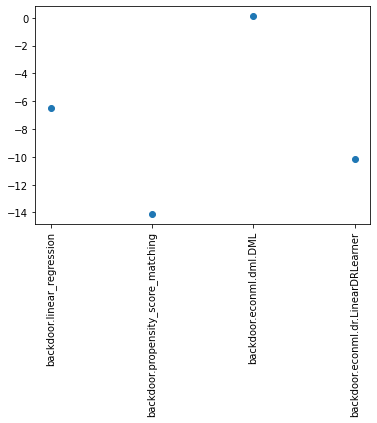

backdoor.linear_regression: -6.527766715878084
backdoor.propensity_score_matching: -14.101250760852881
backdoor.econml.dml.DML: 0.11462015878233744
backdoor.econml.dr.LinearDRLearner: -10.132229850741584


In [12]:
plot_deviations(estimator_list, deviation_list)
for i in range(len(estimator_list)):
    print(estimator_list[i] +": "+ str(deviation_list[i]))

In [13]:
{k: v for k, v in sorted(zip(estimator_list, deviation_list), key=lambda item: item[1], reverse = True)}


{'backdoor.econml.dml.DML': 0.11462015878233744,
 'backdoor.linear_regression': -6.527766715878084,
 'backdoor.econml.dr.LinearDRLearner': -10.132229850741584,
 'backdoor.propensity_score_matching': -14.101250760852881}

### Ranking based on New Effect (Refutatation results) 

The ranking based on absolute value of deviations is :
1. Propensity Score Matching 
2. Linear DR Learner 
3. DML CATE Estimator 
4. Linear Regression

Clearly, the observed unmodelled confounding error is not able to match the ranking based on the Original Estimate. It is not even able to tell that the clear winner amongst the methods according to the true value is DML CATE Estimator 

## Unobserved confounding error

For each estimator, we now simulate unobserved confounders and check its effect using dummy outcome refuter to check the unobserved confounding error for each estimator. That is, we run the refutation test for each estimator not only on the observed confounder, but also on an unobserved confounder that we simulate using the AddUnobservedCommonCause class and analyse whether there is a strong confounder that is unobserved (missing) and needs to be accounted for. 



Running Experiment: Test_2


Running Experiment Number: 0


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[101.00124668],
       [ -0.40524692],
       [  0.5170387 ],
       [  0.22753251],
       [ -0.33111488],
       [ -1.71459508]]), 'confounder=>outcome': array([[ 9.93127757e+01],
       [ 3.62405338e-02],
       [-2.78407796e-01],
       [ 6.66401942e-01],
       [ 1.58592968e+00],
       [ 6.14552640e-01]]), 'effect_modifier=>outcome': array([[ 0.55233584],
       [-1.69288474]]), 'treatment=>outcome': array([[-0.65863375]])}
        bias: {'confounder=>treatment': array([0.25396191]), 'confounder=>outcome': array([0.89578919])}
        seed: None
        treatment_is_binary: True
        percentile: 

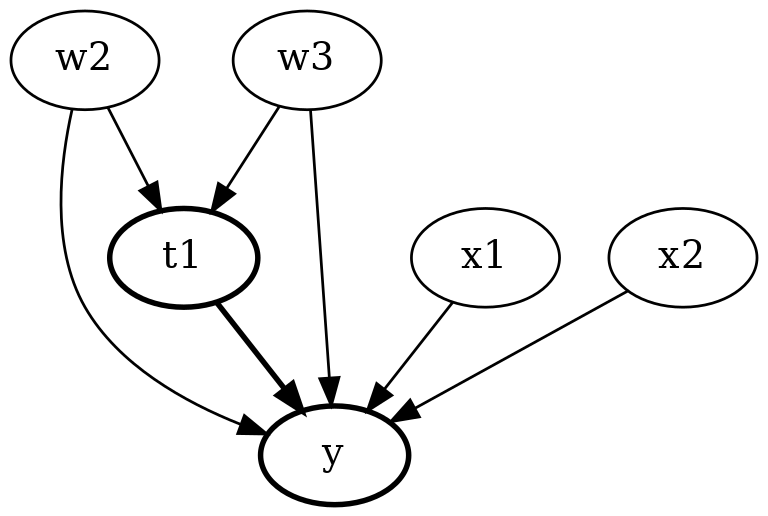

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.L

Co-variance matrix is underdetermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [57.743660855200815, 67.91763375915019, 59.004896606209, 50.75092733049685, 57.956338442680845]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd614a760>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0       483.804671
1       689.570112
2     -1080.236812
3     -2314.720287
4       571.193587
          ...     
995    -877.103757
996    2589.668841
997   -2432.187898
998   

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd614aeb0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0       483.186308
1       688.517970
2     -1078.521044
3     -2316.244611
4       570.541539
          ...     
995    -878.619314
996    2590.119112
997   -2432.916902
998   -2053.859780
999    -592.096918
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd64efa00>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [12.72739953345951, 20.59393984830404, 5.424935717098578, 11.70757669878341, 9.889124115780927]
p_value [0.004051067447440024, 0.041334221466014724, 0.3151033066562853, 0.0309602194798701, 0.16640900068097336]
true value -1.4792516447536492


Running Experiment Number: 1


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.99849473],
       [ -0.12620787],
       [ -0.35105959],
       [  0.73907448],
       [ -0.25379414],
       [  1.25718049]]), 'confounder=>outcome': array([[98.98129862],
       [ 0.61274089],
       [ 0.35170998],
       [-0.71587056],
       [ 0.28451046],
       [-0.62835261]]), 'effect_modifier=>

Co-variance matrix is underdetermined. Inference will be invalid!


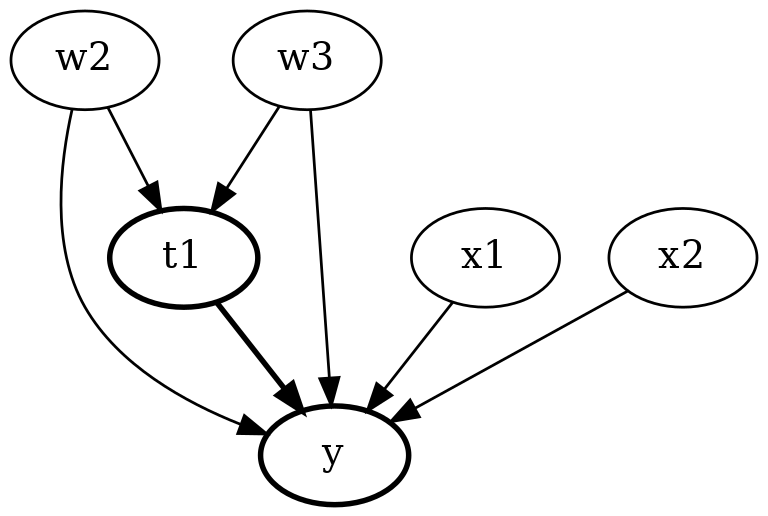

divide by zero encountered in double_scalars


identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimat

Co-variance matrix is underdetermined. Inference will be invalid!


 [69.1312690792075, 75.12540970059287, 68.7369415289937, 78.58427918566144, 68.2063476306856]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0       482.444744
1       686.867483
2     -1078.107061
3     -2315.869680
4       572.129027
          ...     
995    -876.166646
996    2591.387026
997   -2431.122933
998   -2054.540137
999    -590.902789
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd63b3a90>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd6160b80>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0      2043.270665
1     -1617.255425
2      3847.574835
3     -1041.109095
4      -353.275142
          ...     
995    2623.428010
996    -836.757754
997     275.920103
998   -2989.266518
999     432.185750
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd6160d90>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [12.783467983018799, 3.3672820771704224, 9.71080381784804, 6.487175860183404, 8.797041165593232]
p_value [0.06871978589060229, 0.38488190827870866, 0.14434458522324378, 0.32223343535004834, 0.1360585687808496]
true value -0.438348939322492


Running Experiment Number: 2


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.89718755e+01],
       [-1.11033559e+00],
       [-2.80347881e-02],
       [-1.92037239e+00],
       [ 1.16064954e+00],
       [-1.92752106e-01]]), 'confounder=>outcome': array([[ 9.85327330e+01],
       [-2.63044782e-01],
       [ 5.50250436e-01],
       [-2.03863686e+00],
       [-4.53266666e-01],
     

Co-variance matrix is underdetermined. Inference will be invalid!


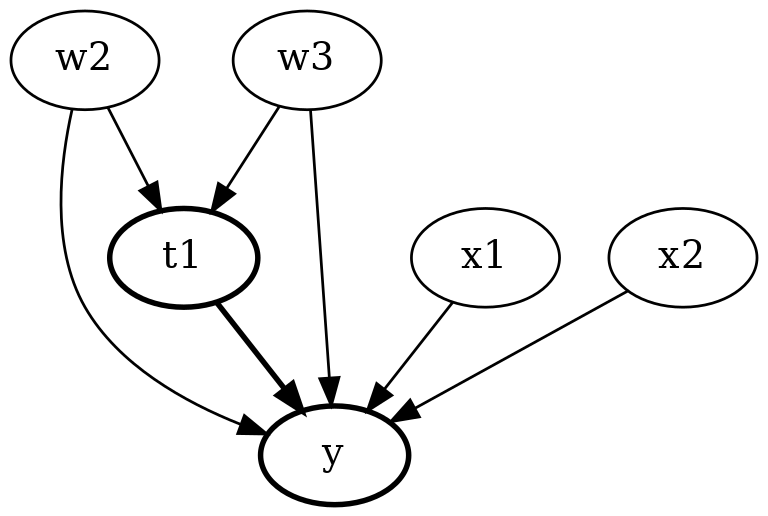

divide by zero encountered in double_scalars


identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimat

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0      2324.381175
1       811.703126
2       574.899955
3     -2367.122999
4     -2661.861379
          ...     
995    -105.619540
996   -2448.271100
997    -666.276847
998    -975.039785
999     187.712091
Length: 1000, dtype: float64}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd629a640>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0      2326.295176
1       811.418534
2       575.254168
3     -2364.080885
4     -2663.737465
          ...     
995    -105.436239
996   -2446.069036
997    -664.659556
998    -973.985533
999     187.773680
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd61e0670>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [9.23152394519441, 11.761155195054744, 9.786721399168453, 8.902622449029248, 6.237668999015385]
p_value [0.13134045210909873, 0.15247524755593378, 0.22714248236716394, 0.29250321781258937, 0.33430968831726315]
true value 0.17176073603891043


Running Experiment Number: 3


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 1.01373505e+02],
       [-8.79791464e-01],
       [ 1.30655924e+00],
       [ 5.44006993e-01],
       [ 3.77329098e-02],
       [-1.33079286e+00]]), 'confounder=>outcome': array([[100.09747927],
       [  1.94516476],
       [ -0.27194547],
       [ -0.36293813],
       [  0.86994839],
       [ -1.0057366

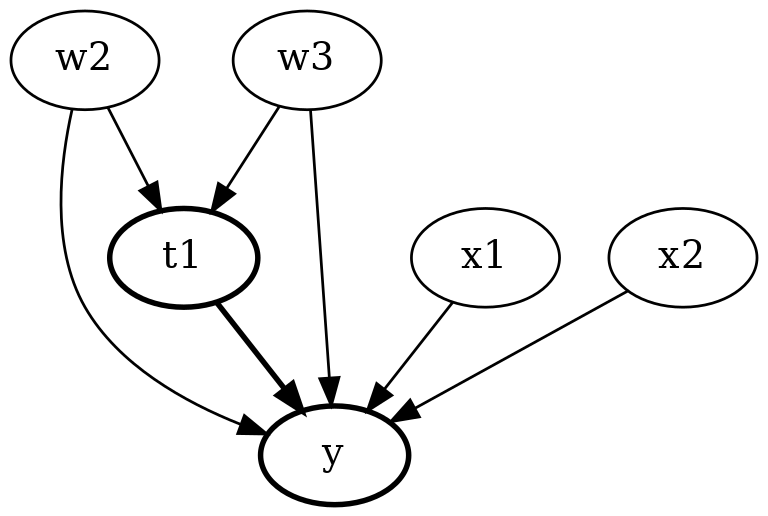

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.L

Co-variance matrix is underdetermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [73.89532688544938, 77.8904356827629, 74.74457894429781, 63.24951324990991, 74.0967358403741]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0      2326.627736
1       814.079617
2       575.030903
3     -2366.377110
4     -2663.575100
          ...     
995    -106.573055
996   -2446.866501
997    -664.782230
998    -974.162653
999     186.524710
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd5ecc610>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], '

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd64a7ee0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0      -500.537467
1       144.438782
2      -913.899936
3     -1634.233019
4      -405.904321
          ...     
995    -316.097894
996   -2838.166864
997    -477.412170
998   -1967.446509
999    -650.897495
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd60a3190>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [3.1821669513286786, 19.00306600100839, 15.274770468298527, -2.826999819276888, 14.996168767259572]
p_value [0.322093141746021, 0.06423107250627727, 0.0179080980703173, 0.25086576096714563, 0.005286419409694664]
true value -0.49594615229449346


Running Experiment Number: 4


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.88532189e+01],
       [-2.85917039e+00],
       [ 3.01422541e-01],
       [ 1.79539299e+00],
       [-3.07605602e-02],
       [-2.64674432e+00]]), 'confounder=>outcome': array([[ 9.84854779e+01],
       [-4.76901944e-02],
       [-2.34089564e+00],
       [-1.46141469e+00],
       [ 4.39515856e-01],
 

Co-variance matrix is underdetermined. Inference will be invalid!


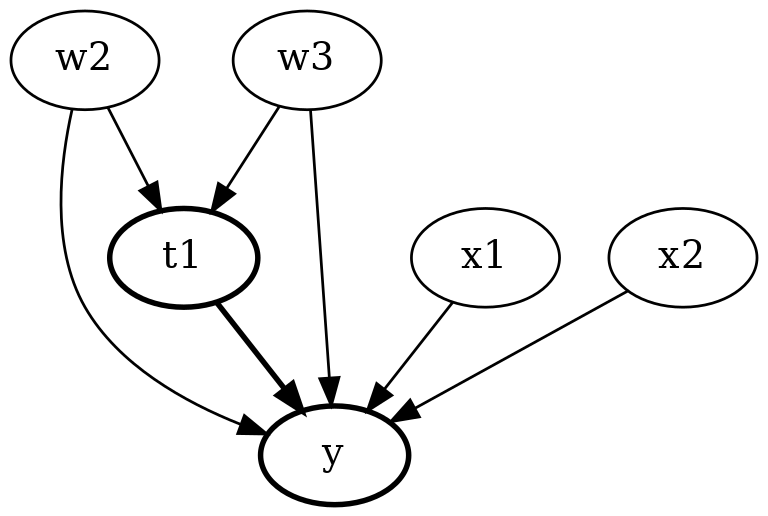

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.L

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0     -1161.161144
1       430.769278
2      2578.780106
3     -1758.912170
4      -315.458176
          ...     
995    1064.535570
996    1313.302303
997     690.856571
998   -1662.466997
999    -507.221330
Length: 1000, dtype: float64}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd604c1c0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0     -1163.320826
1       432.126869
2      2575.995208
3     -1761.314002
4      -312.964753
          ...     
995    1067.789634
996    1313.751829
997     689.171121
998   -1661.008366
999    -504.176955
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd5eebaf0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [5.752672392012465, 3.4454842926300424, 7.692613222302913, 8.316033773262607, 8.715024620140717]
p_value [0.20405903116191598, 0.35128206977631954, 0.03493341338041653, 0.20903423632839307, 0.048729652374770144]
true value 1.4542854047966387


Running Experiment Number: 5


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.07381073],
       [  0.69887629],
       [ -1.50409663],
       [ -0.22733533],
       [ -0.34197954],
       [ -1.42455291]]), 'confounder=>outcome': array([[ 9.95013021e+01],
       [-9.78035847e-01],
       [ 9.07260405e-01],
       [ 1.26383679e-02],
       [-1.19351305e+00],
       [ 3.09935698e-

Co-variance matrix is underdetermined. Inference will be invalid!


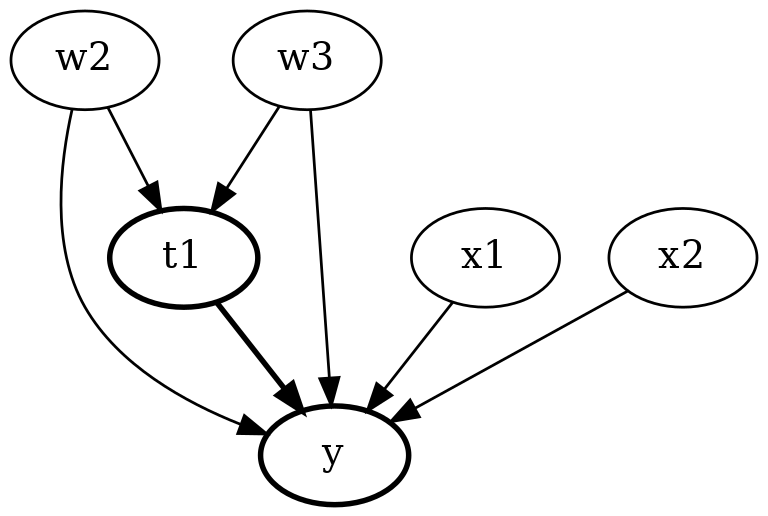

divide by zero encountered in double_scalars


identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimat

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0       640.360148
1      -414.240918
2       391.723483
3      1269.390992
4     -1674.837164
          ...     
995      23.844690
996     -38.458323
997     200.417582
998    2274.059492
999    -253.574014
Length: 1000, dtype: float64}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd5eeb760>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0       638.986841
1      -415.795915
2       393.017730
3      1269.175300
4     -1676.719572
          ...     
995      23.911534
996     -40.703345
997     198.321036
998    2275.582089
999    -254.138662
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd5ec9dc0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-3.0553052708438484, 3.834126108314662, -3.784699864981804, 1.9653639185540954, 2.3181345430823628]
p_value [0.40760718809105423, 0.35148013380814525, 0.3223849632410378, 0.31727497642570845, 0.28818973340163156]
true value 1.5897388790728515


Running Experiment Number: 6


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.6616455 ],
       [ -0.42895713],
       [  1.09037899],
       [  0.84590969],
       [ -0.30647117],
       [ -0.23136794]]), 'confounder=>outcome': array([[100.57472272],
       [  0.70871003],
       [ -0.27223835],
       [  1.24971364],
       [  0.62089401],
       [ -0.31559774]]), 'effect_m

Co-variance matrix is underdetermined. Inference will be invalid!


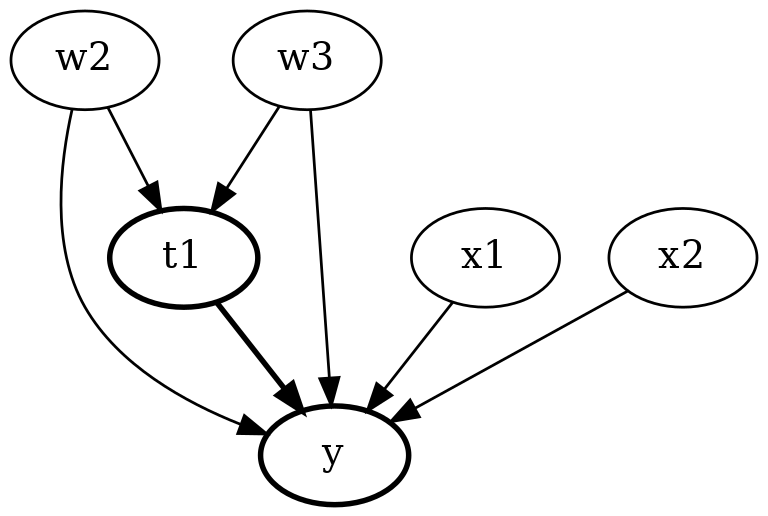

divide by zero encountered in double_scalars


identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimat

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0      1198.774061
1     -3094.015642
2      -479.429142
3      2681.378938
4      1299.676658
          ...     
995    -250.060885
996    -924.134514
997     854.273643
998    1562.733251
999    1551.505577
Length: 1000, dtype: float64}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd5e1c8b0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0      1197.975780
1     -3095.578888
2      -478.164090
3      2681.113617
4      1299.995108
          ...     
995    -251.081148
996    -925.779012
997     851.556058
998    1562.680797
999    1554.471730
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd7872df0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [8.772851754588435, 9.004706359593506, 3.6723782836872503, -6.955434060056518, 4.502694502951849]
p_value [0.002897299339417335, 0.20336783283178794, 0.1991001652636582, 0.23033952259465873, 0.32495548967513993]
true value 2.198862214187046


Running Experiment Number: 7


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.98869493e+01],
       [-1.13681936e+00],
       [ 2.75603217e+00],
       [ 2.56572002e-01],
       [-9.25840136e-02],
       [-2.22344516e-01]]), 'confounder=>outcome': array([[ 9.98439594e+01],
       [-3.30060126e-01],
       [-5.87946264e-02],
       [ 3.73967723e-01],
       [ 3.06772714e-02],
    

Co-variance matrix is underdetermined. Inference will be invalid!


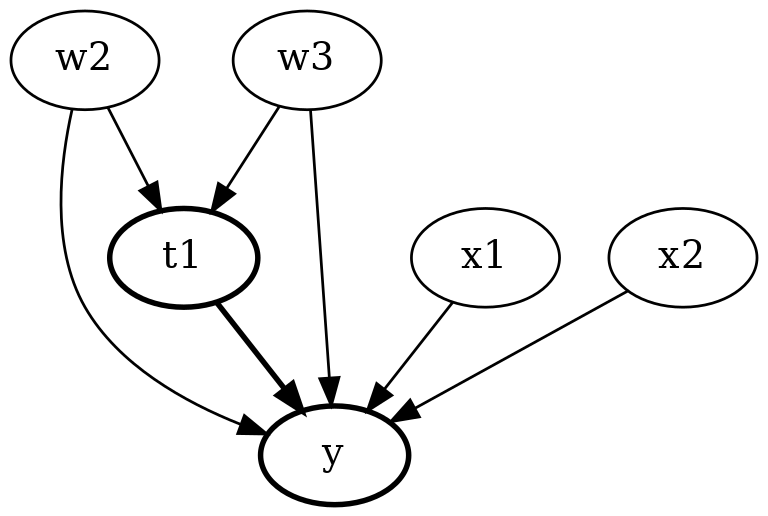

divide by zero encountered in double_scalars


identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimat

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0      -483.107273
1      1766.511793
2      1151.029722
3       -69.053644
4     -1666.924920
          ...     
995   -1083.003886
996   -3880.290916
997   -1745.373776
998    -884.773140
999    -507.564981
Length: 1000, dtype: float64}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd7602670>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0      -483.568157
1      1764.751182
2      1148.323701
3       -69.906515
4     -1664.919934
          ...     
995   -1079.499151
996   -3880.632826
997   -1747.111677
998    -885.071997
999    -506.123495
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd5f7ac40>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [11.29015873612455, 23.0966989075772, 15.752098370792174, -1.0814510752095527e-15, 15.317613886099375]
p_value [0.06744583609018366, 0.0067839004278893115, 1.554515092785375e-07, 0.0, 0.025179345941365918]
true value 1.9013697709213015


Running Experiment Number: 8


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[101.04329645],
       [ -1.42477739],
       [  0.12910115],
       [ -2.4086711 ],
       [  1.35148474],
       [ -0.53420888]]), 'confounder=>outcome': array([[ 1.00836395e+02],
       [ 2.86778069e-01],
       [-5.32798059e-01],
       [-5.55455664e-01],
       [-6.22633817e-01],
       [ 3.74079257e-02]]),

Co-variance matrix is underdetermined. Inference will be invalid!


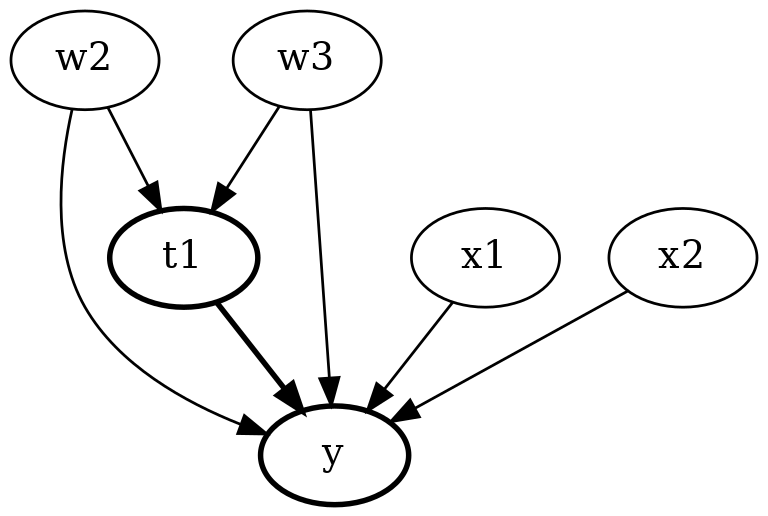

divide by zero encountered in double_scalars


identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimat

Co-variance matrix is underdetermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [81.6809054808668, 73.93059317599061, 82.87635912598003, 69.72627396112352, 81.38742242188542]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0      -483.509361
1      1763.497691
2      1150.632984
3       -67.361909
4     -1667.433840
          ...     
995   -1080.428427
996   -3880.710489
997   -1746.002044
998    -884.263886
999    -506.756083
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd61cce20>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd77605b0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0     -2730.977789
1     -1979.748227
2     -1478.626114
3       984.765083
4     -1244.294386
          ...     
995    2446.616979
996    1445.019955
997      65.951301
998     192.206794
999   -1250.187198
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd7810d60>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [10.358996325450333, 11.953475875366825, 15.147792801124746, 9.68305267576063, 11.876485547321412]
p_value [0.16752304101841697, 0.016643313969100095, 0.03692242546938662, 0.1265665991610777, 0.013101588992833346]
true value -0.8225380783795481


Running Experiment Number: 9


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.24237925],
       [ -0.21827098],
       [ -0.96245278],
       [  0.55238076],
       [  0.74057163],
       [ -0.27170669]]), 'confounder=>outcome': array([[100.12906499],
       [ -1.13978644],
       [  0.40978863],
       [  0.36831502],
       [ -0.97362408],
       [  1.23815881]]), 'effect_

Co-variance matrix is underdetermined. Inference will be invalid!


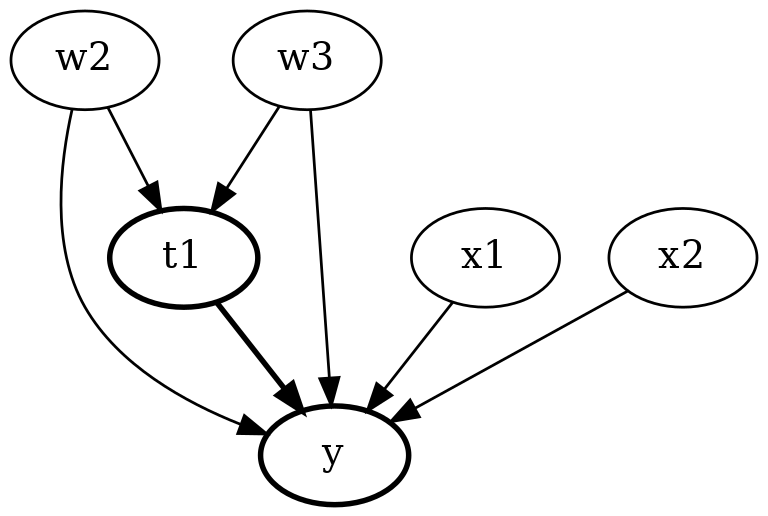

divide by zero encountered in double_scalars


identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimat

Co-variance matrix is underdetermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [62.620191058560735, 60.36925081804303, 63.46488888544051, 66.13245967247609, 62.72009643179072]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0     -2730.498454
1     -1978.934738
2     -1478.273642
3       984.297759
4     -1245.176502
          ...     
995    2446.900914
996    1444.806459
997      65.491972
998     191.398483
999   -1249.641841
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd75eedc0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})]

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd606d1f0>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f7c8cc6fb80>, 'unobserved_confounder_values': 0      -629.372633
1     -2047.317343
2       327.291513
3     -1462.951339
4     -2073.083074
          ...     
995   -1946.078043
996   -1345.377960
997     378.563065
998    1277.353782
999   -2195.211673
Length: 1000, dtype: float64}
printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7bd62b1910>
refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect'

Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [4.123033667137402, 0.28695572196469926, 1.642707655034208, 2.39405162391286, -4.778070114934404]
p_value [0.17330940079867413, 0.4884486913204257, 0.43083645084106126, 0.34620947010498443, 0.11667897742610545]
true value -1.3779277530151717


Completed all experiments. Saving the data...
Data has been saved in  results/Test_2_2021-12-16_data.csv


Co-variance matrix is underdetermined. Inference will be invalid!


In [14]:
unobserved_confounding_error = Experiment(
    experiment_name='Test',
    experiment_id='2',
    num_experiments=10, # 10
    sample_sizes=sample_size,
    dgps=dgp_list,
    estimators=estimator_tuples,
    refuters=refuter_tuples,
    simulate_unobserved_confounding = True
)

# Run the experiment
res = pd.read_csv(unobserved_confounding_error.experiment())

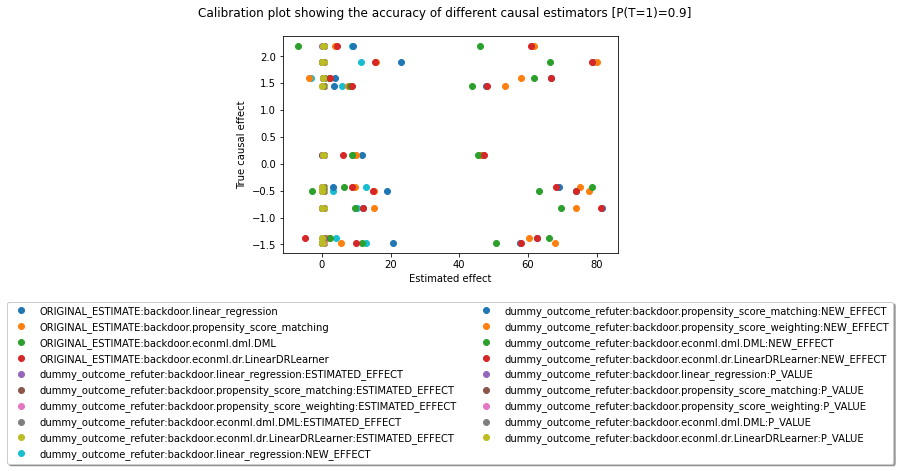

Printing MAE of various estimates: 
ORIGINAL_ESTIMATE:backdoor.propensity_score_matching 65.15520044714417
ORIGINAL_ESTIMATE:backdoor.linear_regression 64.37077152846932
ORIGINAL_ESTIMATE:backdoor.econml.dr.LinearDRLearner 64.30634752237276
ORIGINAL_ESTIMATE:backdoor.econml.dml.DML 58.92980356995965
dummy_outcome_refuter:backdoor.propensity_score_matching:NEW_EFFECT 10.364488594973313
dummy_outcome_refuter:backdoor.propensity_score_weighting:NEW_EFFECT 8.836699492123099
dummy_outcome_refuter:backdoor.econml.dr.LinearDRLearner:NEW_EFFECT 8.19701663188975
dummy_outcome_refuter:backdoor.linear_regression:NEW_EFFECT 8.175504988005276
dummy_outcome_refuter:backdoor.econml.dml.DML:NEW_EFFECT 6.374487810719598
dummy_outcome_refuter:backdoor.linear_regression:ESTIMATED_EFFECT 1.2586508100704281
dummy_outcome_refuter:backdoor.propensity_score_matching:ESTIMATED_EFFECT 1.2586508100704281
dummy_outcome_refuter:backdoor.propensity_score_weighting:ESTIMATED_EFFECT 1.2586508100704281
dummy_outcome_r

In [15]:
##This plot shows the Mean Absolute Error of the Orginal Estimate from the true value and of the New Effect from 
#the expected value for each estimator.
plot_MAEs(res)

### Ranking based on Original Estimate

The Original Estimate is calculated in the presence of the True Value (that is, the ground truth). However in many real life datasets, the ground truth may not be known. Hence, we want the ranking produced by our refutation tests to be in coherence with that obtained from the Original Estimates. According to the Original Estimate values, the ranking of the estimators should be as follows (the method with the least MAE should get the best rank):
1. DMLCateEstimator 
2. Propensity Score Matching 
3. LinearRegression 
4. LinearDRLearner 

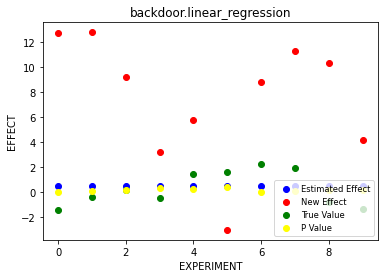

75.16696601747074


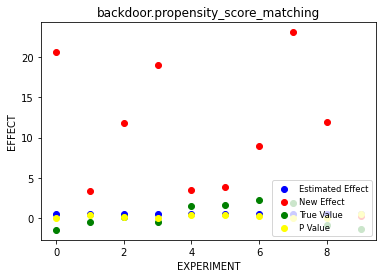

106.34689038698453


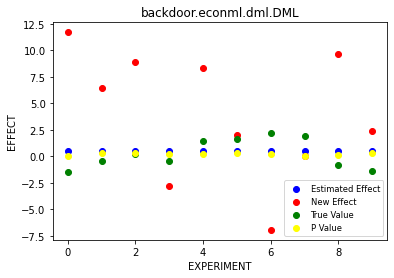

39.67344312015284


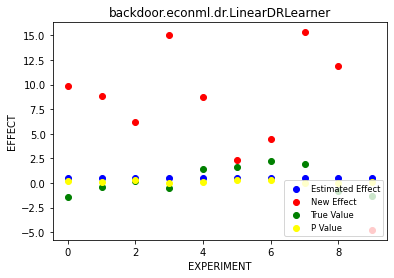

77.87188603231043


<Figure size 432x288 with 0 Axes>

In [16]:
#This plot shows the deviation of the original estimate, the new effect and the estimated effect from the true value
refuter = 'dummy_outcome_refuter'
deviation_list = []
for estimator in estimator_list:
    plot_estimators_and_refuters(refuter, estimator)
    avg_deviation = ((res[refuter+':'+estimator+':NEW_EFFECT']).sum(axis=0))
    print(avg_deviation)
    deviation_list.append(avg_deviation)

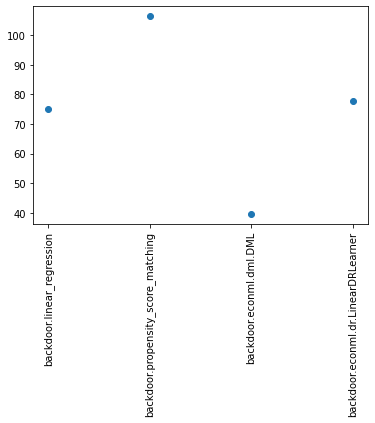

backdoor.linear_regression: 75.16696601747074
backdoor.propensity_score_matching: 106.34689038698453
backdoor.econml.dml.DML: 39.67344312015284
backdoor.econml.dr.LinearDRLearner: 77.87188603231043


In [17]:
plot_deviations(estimator_list, deviation_list)
for i in range(len(estimator_list)):
    print(estimator_list[i] +": "+ str(deviation_list[i]))

In [18]:
{k: v for k, v in sorted(zip(estimator_list, deviation_list), key=lambda item: item[1], reverse = True)}

{'backdoor.propensity_score_matching': 106.34689038698453,
 'backdoor.econml.dr.LinearDRLearner': 77.87188603231043,
 'backdoor.linear_regression': 75.16696601747074,
 'backdoor.econml.dml.DML': 39.67344312015284}

### Ranking based on New Effect (Refutatation results) 

The ranking based on absolute value of deviations is :
1. DML
2. Linear DR Learner 
3. Propensity Score Matching
4. Linear Regression

#### We can see that this ranking produces the same top-ranked estimator as the one based on Original Estimate. Thus ranking based on the unobserved confounding error solves the problem and gives us a close-to-correct ranking amongst methods.